In [1]:
%matplotlib inline

import glob
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import shutil
import skimage.io as io

In [2]:
TRAIN_PATH = 'data/Train/'
TEST_PATH = 'data/Test/'
VALIDATION_PATH = 'data/Validation/'

### Dataset Sizes

In [3]:
def set_size_summary(base_dir, subsets=['']):
    num_images = 0
    imgs_paths = []
    for class_folder in os.listdir(base_dir):
        for subset in subsets:
            if subset:
                imgs_paths.extend(glob.glob(f'{base_dir}{class_folder}/{subset}/*.ppm'))
            else:
                imgs_paths.extend(glob.glob(f'{base_dir}{class_folder}/*.ppm'))        
            imgs_count = len(imgs_paths)
            num_images += imgs_count
            print(f'{imgs_count} images of class {class_folder}.')
    print(f'\nTotal number of images: {num_images}')

In [4]:
def plot_sample_paths(base_dir):
    paths = glob.glob(f'{base_dir}/**/*.ppm', recursive=True)
    samples = np.random.choice(paths, 3, replace=False)
    fig=plt.figure(figsize=(10, 10))
    for n, sample in enumerate(samples, 1):
        fig.add_subplot(1, 3, n)
        img = plt.imread(sample)
        plt.imshow(img)
    plt.show();

- Training Set

Checking training set class distribution:

In [5]:
!ls {TRAIN_PATH}

A  B  C  Five  Point  V


In [6]:
set_size_summary(TRAIN_PATH)

572 images of class C.
1901 images of class A.
3296 images of class Point.
3950 images of class Five.
4385 images of class V.
4872 images of class B.

Total number of images: 18976


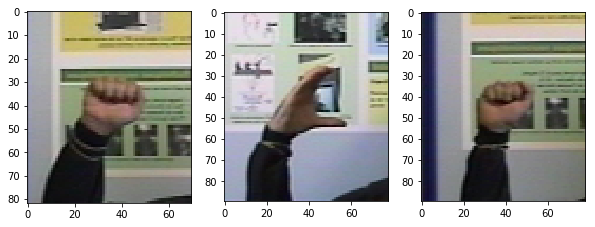

In [7]:
plot_sample_paths(TRAIN_PATH)

- Test Set

And also our test set distribution:

In [8]:
!ls {TEST_PATH}

A  B  C  Five  Point  V


In [9]:
for class_folder in os.listdir(TEST_PATH):
    imgs_paths = glob.glob(f'{TEST_PATH}{class_folder}/complex/*.ppm')
    imgs_paths.extend(glob.glob(f'{TEST_PATH}{class_folder}/uniform/*.ppm'))
    imgs_count = len(imgs_paths)
    print(f'{imgs_count} images of class {class_folder}.')

112 images of class C.
97 images of class A.
119 images of class Point.
134 images of class Five.
95 images of class V.
102 images of class B.


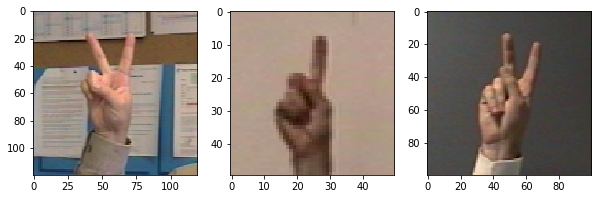

In [ ]:
plot_sample_paths(TEST_PATH)

### Create Validation Set

Creating a validation set from training set:

In [ ]:
for class_folder in os.listdir(TRAIN_PATH):
    imgs_paths = glob.glob(f'{TRAIN_PATH}{class_folder}/*.ppm')
    np.random.shuffle(imgs_paths)
    if not os.path.exists(f'{VALIDATION_PATH}'):
        os.mkdir(f'{VALIDATION_PATH}')
    if not os.path.exists(f'{VALIDATION_PATH}{class_folder}/'):
        os.mkdir(f'{VALIDATION_PATH}{class_folder}/')
    for image_path in imgs_paths[:int(len(imgs_paths)*0.2)]:
        shutil.move(image_path, os.path.join(f'{VALIDATION_PATH}{class_folder}', os.path.basename(image_path)))

In [ ]:
set_size_summary(TRAIN_PATH)

In [ ]:
set_size_summary(VALIDATION_PATH)

### Image dimensions

Let's find the average dimensions of the images in the dataset so we can resize them with minimum distortions:

In [ ]:
def load_collection(dirs):
    imgs = io.ImageCollection(dirs)
    return imgs

In [ ]:
train_imgs = load_collection(glob.glob(f'{TRAIN_PATH}/**/*.ppm'))
dims = np.array([[h.shape[0], h.shape[1]] for h in train_imgs])

In [ ]:
dims.shape

In [ ]:
np.mean(dims[:,0]), np.mean(dims[:,1]), np.std(dims[:,0]), np.std(dims[:,1])

In [ ]:
np.max(dims[:,0]), np.min(dims[:,0])

In [ ]:
np.max(dims[:,1]), np.min(dims[:,1])

In [ ]:
mean_h, mean_w = int(np.mean(dims[:,0])), int(np.mean(dims[:,1]))
mean_h, mean_w